In [11]:
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import (
    diffeqsolve, ODETerm, Dopri5, ControlTerm, 
    Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun,
    WeaklyDiagonalControlTerm,
)
from tqdm.auto import tqdm


#### Stochastic interpolants example (SDE)

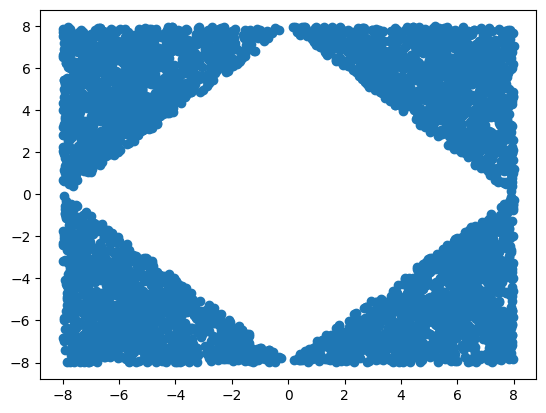

In [2]:
num_target = 5000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 8 * target_samples[jnp.sum(jnp.abs(target_samples),1)>1.][:num_target]

num_reference = 10000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))
plt.scatter(target_samples[:,0],target_samples[:,1])

In [3]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3,key4 = jax.random.split(key, 4)
        # These contain trainable parameters.

        num_params_per_layer  = 256
        self.layers = [eqx.nn.Linear(3, num_params_per_layer, key=key1),
                       jax.nn.elu,
                       eqx.nn.Linear(num_params_per_layer, num_params_per_layer, key=key2),
                       jax.nn.elu,
                       eqx.nn.Linear(num_params_per_layer, num_params_per_layer, key=key3),
                       jax.nn.elu,
                       eqx.nn.Linear(num_params_per_layer, 2, key=key4)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return jnp.cos(t)*x + jnp.sin(t)*y

def It(t,x,y):
    return -jnp.sin(t)*x + jnp.cos(t)*y

def gamma(t):
    return jnp.sqrt(2*t*(1-t)+1e-8)

gammadot = vmap(vmap(grad(gamma)))


@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(b_model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    bhat = jax.vmap(b_model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gammadot(t)*z)*bhat,axis=1))
#     dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - 2*dot_term
    # return jnp.mean((bhat - (It(t,x,y) + gammadot(t)*z))**2)

def loss_denoise(eta_model,t,x,y,z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    etahat = jax.vmap(eta_model)(tx)  # vectorise the model over a batch of data
    
    etanorm2 = jnp.mean(jnp.sum(etahat**2,axis=1))
    dot_term = jnp.mean(jnp.sum(etahat*z,axis=1))
    return etanorm2 - 2*dot_term

In [4]:
# t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
# z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
# model = NeuralNetwork(jax.random.PRNGKey(0))
# loss(model,t,reference_samples,target_samples,z)
# loss_denoise(model,t,reference_samples,target_samples,z)

In [5]:
def evaluate_b(b_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(b_model,t,x,y,z)
    return avg_loss / 100

def evaluate_eta(eta_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss_denoise(eta_model,t,x,y,z)
    return avg_loss / 100

In [6]:
def self_stack(x):
    return jnp.vstack([x,x])
def get_trainloader(batch_size = 512):
    assert batch_size%2==0
    batch_num = 0
    while True:
        batch_num+=1
        trainloader_key = jax.random.PRNGKey(batch_num//2)
        ref_key,target_key,normal_key,t_key = jax.random.split(trainloader_key,4)
        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))
        t_vals = jax.random.uniform(t_key,(batch_size,1))
        z = jax.random.normal(normal_key,ref_batch.shape)
        yield self_stack(t_vals),self_stack(ref_batch),self_stack(target_batch),jnp.vstack([z,-z])

def get_testloader(batch_size = 1000):
    assert batch_size%2==0
    num_batches = 100
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield self_stack(t_vals),self_stack(ref_batch),self_stack(target_batch),jnp.vstack([z,-z])

In [7]:
def train_eta(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss_denoise)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(tqdm(range(steps)), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan Obtained")
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_eta(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

def train_b(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(tqdm(range(steps)), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan Obtained")
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_b(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

In [8]:
lr_shifts = {
      100:0.2,
      1000:0.5,
      2000:0.2,
      5000:0.5,
      10000:0.5,
      15000:0.5,
      20000:0.5
   }

schedule = optax.piecewise_constant_schedule(
   1e-2,lr_shifts
)

b_optim = optax.chain(
   optax.adam(schedule),
)
b_model = NeuralNetwork(jax.random.PRNGKey(420))
b_trainloader = get_trainloader(batch_size = 2048)

b_model,b_losses = train_b(b_model,b_optim,steps=40000,train_loader=b_trainloader,print_every=5000)

  0%|          | 0/40000 [00:00<?, ?it/s]

step=0 | train_loss=3.0923629 | test_loss= -16.169962
step=5000 | train_loss=-31.885887 | test_loss= -32.04974
step=10000 | train_loss=-32.64885 | test_loss= -32.073494
step=15000 | train_loss=-32.19979 | test_loss= -32.079597
step=20000 | train_loss=-32.058647 | test_loss= -32.083496
step=25000 | train_loss=-31.646778 | test_loss= -32.087486
step=30000 | train_loss=-31.538183 | test_loss= -32.08768
step=35000 | train_loss=-32.712925 | test_loss= -32.089947
step=39999 | train_loss=-31.490314 | test_loss= -32.090008


In [9]:
# lr_shifts = {
#       1000:0.5,
#       5000:0.1,
#       10000:0.5,
#       15000:0.5,
#       20000:0.5
#    }


# schedule = optax.piecewise_constant_schedule(
#    1e-2,lr_shifts
# )


# eta_optim = optax.chain(
#    optax.adam(schedule),
# )

eta_learning_rate = 1e-4

eta_optim = optax.chain(
   optax.clip_by_global_norm(1.0),
   optax.adamw(eta_learning_rate),
)

eta_trainloader = get_trainloader(batch_size = 2048)

eta_model = NeuralNetwork(jax.random.PRNGKey(420))
eta_model,eta_losses = train_eta(eta_model,eta_optim,steps=40000,train_loader=eta_trainloader,print_every=5000)

  0%|          | 0/40000 [00:00<?, ?it/s]

step=0 | train_loss=2.1416857 | test_loss= 2.004688
step=5000 | train_loss=-0.28220338 | test_loss= -0.26015744
step=10000 | train_loss=-0.2705882 | test_loss= -0.26147023
step=15000 | train_loss=-0.26439178 | test_loss= -0.26226982
step=20000 | train_loss=-0.27163267 | test_loss= -0.26238987
step=25000 | train_loss=-0.25494835 | test_loss= -0.26250607
step=30000 | train_loss=-0.2593177 | test_loss= -0.26312158
step=35000 | train_loss=-0.26574516 | test_loss= -0.26340458
step=39999 | train_loss=-0.26218224 | test_loss= -0.2637555


In [28]:
eps = 20.
epsilon = lambda t: t*(1-t)*eps 

vmapped_b_model = vmap(b_model)
vmapped_eta_model = vmap(eta_model)

@eqx.filter_jit
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x])) - (epsilon(t)/(gamma(t)+1e-12))*vmapped_eta_model(jnp.hstack([t_vec,x]))


X0 = reference_samples.copy()


t0, t1 = 0.0, 1.0
diffusion = lambda t, x, args: jnp.sqrt(2*epsilon(t)) #* jnp.ones_like(x)

brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-6, shape=X0.shape, key=jax.random.PRNGKey(103))
terms = MultiTerm(ODETerm(dX_t), WeaklyDiagonalControlTerm(diffusion, brownian_motion))



solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.001, y0=X0, saveat=saveat)
X = sol.evaluate(1.0)
#print(X)  

In [31]:
time_points = np.linspace(0,1,1000)

path = jnp.array([sol.evaluate(t)[:20] for t in time_points])

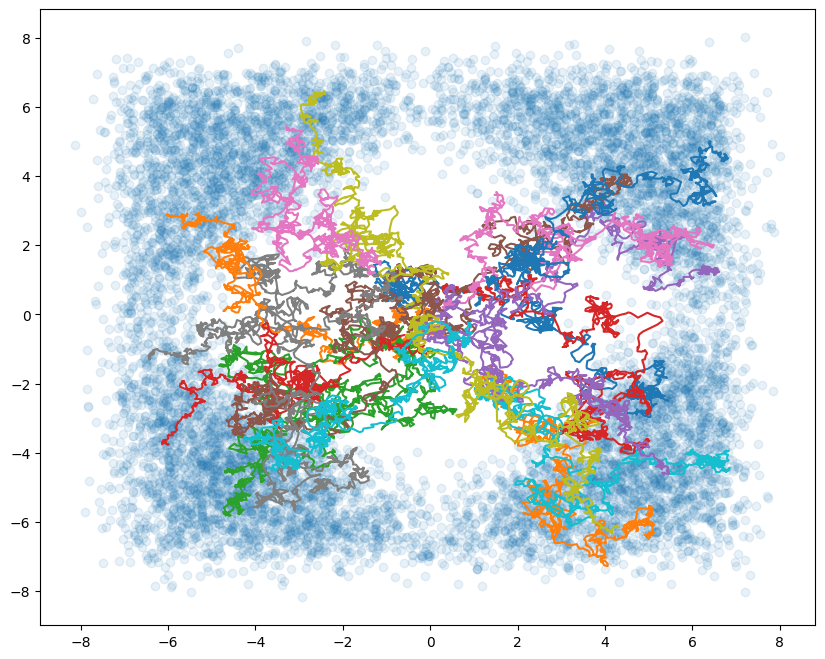

In [32]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.1)
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1])

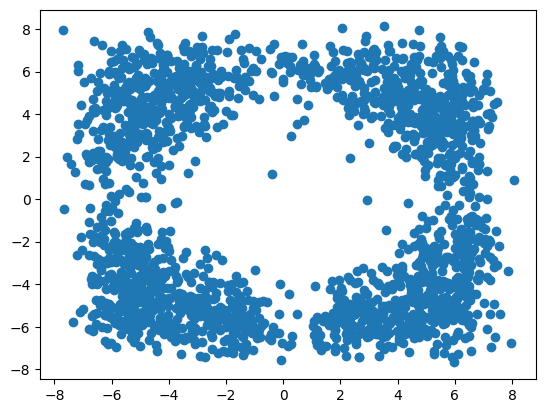

In [26]:
plt.scatter(X[:,0],X[:,1])

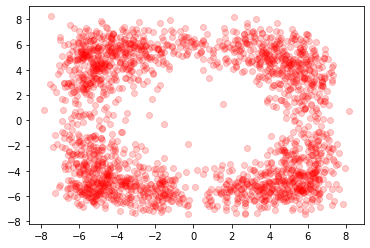

In [131]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)

In [ ]:
from diffrax import WeaklyDiagonalControlTerm

eps = 1.
X0 = jax.random.normal(jax.random.PRNGKey(3),(10,2))

t0, t1 = 0.0, 1.0
diffusion = lambda t, x, args: jnp.ones(2)

brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape = (2,), key=jax.random.PRNGKey(103))
terms = MultiTerm(ODETerm(lambda t,x,args:0 * x), WeaklyDiagonalControlTerm(diffusion, brownian_motion))

solver = Euler()
saveat = SaveAt(dense=True)


def solve_sde(x0):
    return diffeqsolve(terms, solver, t0, t1, dt0=0.001, y0=x0, saveat=saveat)

sol = solve_sde(jnp.array([0,0]))
X = sol.evaluate(1.0)
#print(X)  

time_points = np.linspace(0,1,500)
path = jnp.array([sol.evaluate(t) for t in time_points])
plt.plot(path[:,0],path[:,1])

# Make pretty flow plots later

In [120]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(500):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1],c='blue',alpha = 0.05,lw = 5)

NameError: name 'X_hist' is not defined

In [ ]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=1., dt0=0.01, y0=X0)